In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000
import LMC
import archinfo
import imp
import astropy.stats
import scipy
import scipy.signal as sig
import scipy.optimize as op
from scipy.optimize import curve_fit
import dcor
import random
import collections
import sys
from forecaster_master import mr_forecast as mr

from scipy import stats
from timeit import default_timer

from sklearn.cluster   import KMeans
from sklearn.cluster   import SpectralClustering
from sklearn.neighbors import DistanceMetric
from sklearn.linear_model import LinearRegression

from KDEpy import FFTKDE

'''
Define a few constants
'''

pi = np.pi
MJUPITER = 1.898e27     #all in SI units
MEARTH = 5.972e24
MSUN = 1.989e30
RJUPITER = 69.911e6
RSUN = 696.34e6
MSATURN = 5.6834e26
BIGG = 6.67e-11
MURANUS = 8.681e25

AU = 1.496e11

REARTH = 6371e3
RNEPTUNE = 24622e3

robinseggblue = '#bfe2ff'    #define a few colors
royalpurple = '#9e00a3'
lavender = '#cc98d9'

NBOOT = 16
NTRIALS = 1000

In [2]:
class System:
    def __init__(self, sysid=None):
        
        self.sysid = sysid

In [3]:
#my_file = 'C:/Users/djhoo/Documents/maiasaurus-master/catalogues/exoarchive_dr25_cks_combined.csv'
my_file = 'C:/Users/djhoo/Documents/maiasaurus-master/catalogues/oviraptor_master.csv'
raw_data = []
with open(my_file) as infile:
    reader = csv.reader(infile)
    
    for row in reader:
        raw_data.append(row)
        
KEYS = raw_data[0]
VALUES = raw_data[1:]

def get_key(keyname, keys = KEYS, values = VALUES):
    '''
    keyname must be a string
    '''
    i = keys.index(keyname)
    arr = []
    for row in values:
        arr.append(row[i])
    return np.array(arr)

In [4]:
# CONVERT STRINGS TO FLOATS
def is_number(s):
    '''
    checks if input string s is a number
    or if every entry in a list s is a number
    '''
    if type(s) != list:
        try:
            float(s)
            return True
        except ValueError:
            return False
    else:
        for part in s:
            status = True
            try:
                float(part)
                status = True
            except ValueError:
                status = False
        return status
    
def either_mass_or_radius(masses, radii):
    '''
    Every planet must have a measured mass or radius to be included in our study.
    Otherwise, we have nothing to work with.
    '''
    arr = []
    for i in range(len(masses)):
        if is_number(masses[i]) or is_number(radii[i]):
            arr.append(True)
        else:
            arr.append(False)
    return np.array(arr)
    

d = {}
d['starname'] = get_key('Starname')
d['rp'] = get_key('Rp')
d['mp'] = get_key('Mp')
d['ms'] = get_key('Ms')
d['rs'] = get_key('Rs')
d['p'] = get_key('P')
d['disc_method'] = get_key('Detection Method')              #'disc_method' varies within a system
d['sys_disc_method'] = get_key('System Detection Method')   #'sys_disc_method' should be constant for every planet
                                                            #within a system

legitimate_entries = either_mass_or_radius(d['mp'], d['rp'])

print('Removed the following systems because they have exoplanets without both a mass and radius:')
for s in d['starname'][legitimate_entries == False]:
    print(s)

d['starname'] = d['starname'][legitimate_entries == True]           #all entries with True have either a measured
d['rp'] = d['rp'][legitimate_entries == True]                       #mass or radius
d['mp'] = d['mp'][legitimate_entries == True]
d['ms'] = d['ms'][legitimate_entries == True]
d['rs'] = d['rs'][legitimate_entries == True]
d['p'] = d['p'][legitimate_entries == True]                         #We are simply removing planets without either
d['disc_method'] = d['disc_method'][legitimate_entries == True]     #a measured mass or radius
d['sys_disc_method'] = d['sys_disc_method'][legitimate_entries == True]

d0 = d.copy()

Removed the following systems because they have exoplanets without both a mass and radius:
HIP 41378
HIP 41378
HIP 41378
HIP 41378
HIP 41378
Kepler-37
Kepler-415
Kepler-416
Kepler-417


In [5]:
def probabilistic_mass_radius(arr, m_or_r):
    mean = np.mean(arr)
    std = np.mean(arr)
    if m_or_r == 'm':
        median, up, down = mr.Mstat2R(mean, std, unit='Earth', sample_size=100)
    else:
        median, up, down = mr.Rstat2M(mean, std, unit='Earth', sample_size=100)
    return median

In [6]:
def mass_radius(mp): 
    '''
    mp - float 
    
    Uses the mass-radius relation given in Chen and Kipping (2017).  This method takes mass and 
    outputs radius.  mp is given in Earth masses, and rp is returned in Earth radii.  The specific numbers were obtained
    from here: https://exoplanetarchive.ipac.caltech.edu/docs/pscp_calc.html.
    '''
    mp = float(mp)
    if mp <= 2:                                          
        rp = 10**0.00346*mp**0.2790
    elif mp*MEARTH/MJUPITER <= 0.41:
        rp = 10**-0.0925*mp**0.589
    elif mp*MEARTH/MSUN <= 0.08:
        rp = 10**1.25*mp**-0.044
    else:
        rp = 10**-2.85*mp**0.881
    return rp

for i in range(len(d['mp'])):
    if d['rp'][i] == '' and is_number(d['mp'][i]) == True:        #implementing mass-radius relation 
        d['rp'][i] = mass_radius(d['mp'][i]) 
        
def radius_mass(rp):
    '''
    rp - float  
    
    Takes a radius measurement and outputs its corresponding mass using the mass-radius relation in Chen and Kipping
    (2017).  This is kind of like the inverse of mass_radius above.  The specific numbers were obtained from here: 
    https://exoplanetarchive.ipac.caltech.edu/docs/pscp_calc.html
    '''
    rp = float(rp)
    if rp < 1.23:
        mp = 10**((np.log10(rp)-0.00346)/0.2790)
    elif rp <= 11.1:
        mp = 10**((np.log10(rp)+0.0925)/0.589)
    else:
        mp = 0
    return mp

for i in range(len(d['rp'])):
    if d['mp'][i] == '' and is_number(d['rp'][i]) == True:             #implementing radius-mass relation
        d['mp'][i] = radius_mass(d['rp'][i])

In [7]:
def positivity_condition(masses):
    '''
    Since the radius-mass relation yields m=0 for r>11.1, we must eliminate systems that are within this range.
    Thus, we only need to check if m=0.  Later, we remove planets in which m=0.
    '''
    entries = []
    for i in range(len(masses)):
        if float(masses[i]) <= 0:
            entries.append(False)
        else:
            entries.append(True)
    return np.array(entries)

legitimate_entries = positivity_condition(d['mp'])

d['mp'] = d['mp'][legitimate_entries == True]
d['rp'] = d['rp'][legitimate_entries == True]
d['starname'] = d['starname'][legitimate_entries == True]
d['ms'] = d['ms'][legitimate_entries == True]
d['rs'] = d['rs'][legitimate_entries == True]
d['p'] = d['p'][legitimate_entries == True]
d['disc_method'] = d['disc_method'][legitimate_entries == True]
d['sys_disc_method'] = d['sys_disc_method'][legitimate_entries == True]

In [8]:
# QUICKLY CLEAN DATA

d = d0.copy()

KEY0 = 'starname'

def check_lengths(d, key0=KEY0):
    '''
    checks that all data arrays are the same length
    '''
    keys = d.keys()    
    L0   = len(d[key0])
        
    for k in keys:
        if len(d[k]) != L0: raise ValueError('inconsistent array length for array "%s"' %k)
            
    return None


def convert_to_arrays(d):
    keys = d.keys()
    dnew = {}
    
    for k in keys:
        dnew[k] = np.asarray(d[k])
        
    return dnew

    
    
def remove_missing_data(d, key0=KEY0):
    '''
    removes empty data cells
    '''
    keys = d.keys()
    L0   = len(d[key0])
    dnew = {}
    
    empty = np.zeros(L0)
    
    for k in keys:
        empty += d[k] == ''
    
    empty = empty > 0.0
    
    print('Removed the following systems because they had missing data:')
    for s in d['starname'][empty]:
        print(s)

    for k in keys:
        dnew[k] = d[k][~empty]

    check_lengths(dnew)
    
    return dnew


# CLEAN DATA
d = convert_to_arrays(d)
print('total number of queried objects =', len(d[KEY0]))

d = remove_missing_data(d)
print('after removing missing data, number of objects =', len(d[KEY0]))

check_lengths(d)

def convert_floats(d):
    '''
    converts numerical arrays from strings to floats
    '''
    keys = d.keys()
    dnew = {}
       
    for k in keys:
        if is_number(d[k][0]):
            dnew[k] = np.asarray(d[k],dtype='float')
        else:
            dnew[k] = np.asarray(d[k])
    
    return dnew

# CONVERT STRINGS TO FLOATS (where applicable)
d = convert_floats(d)

total number of queried objects = 4088
Removed the following systems because they had missing data:
BD-06 1339
BD-06 1339
CI Tau
CoRoT-20
CoRoT-20
EPIC 201238110
EPIC 201497682
EPIC 201841433
EPIC 206024342
EPIC 206032309
EPIC 206042996
EPIC 206215704
EPIC 206317286
EPIC 212297394
EPIC 212424622
EPIC 212499991
EPIC 212587672
GJ 160.2
GJ 163
GJ 163
GJ 163
GJ 180
GJ 180
GJ 180
GJ 2056
GJ 229
GJ 229
GJ 27.1
GJ 3082
GJ 317
GJ 317
GJ 328
GJ 422
GJ 433
GJ 433
GJ 433
GJ 480
GJ 649
GJ 667 C
GJ 667 C
GJ 674
GJ 682
GJ 682
GJ 687
GJ 687
GJ 832
GJ 832
GJ 9066
GJ 9066
GJ 96
HAT-P-13
HAT-P-13
HAT-P-4
HD 102365
HD 102843
HD 103774
HD 103949
HD 107148
HD 109271
HD 109271
HD 114783
HD 114783
HD 117618
HD 12484
HD 129445
HD 133131 A
HD 133131 A
HD 133131 B
HD 134060
HD 134060
HD 136352
HD 136352
HD 136352
HD 141399
HD 141399
HD 141399
HD 141399
HD 143105
HD 1461
HD 1461
HD 147018
HD 147018
HD 147379
HD 147513
HD 160691
HD 160691
HD 160691
HD 160691
HD 16417
HD 164595
HD 164604
HD 166724
HD 167042
HD 169

In [9]:
d['logg'] = np.log10(BIGG*(d['ms']*MSUN)/(d['rs']*RSUN)**2)
d['rprs'] = np.zeros(len(d['mp']))
for i in range(len(d['rprs'])):
    d['rprs'][i] = d['rp'][i]*REARTH/(d['rs'][i]*RSUN)

In [10]:
def my_sigma_clip(data, niter = 3, s_th = 3.):
    '''
    returns mean, variance, standard deviation, and outliers flagged
    '''
    if type(data) != np.ndarray:
        data = np.array(data)
    outliers = np.array([True]*len(data))
    while niter > 0:
        mean, std = np.mean(data[outliers == True]), np.std(data[outliers == True])
        status = []
        for i in range(len(data)):
            if outliers[i] == False:
                status.append(False)
            elif (data[i]-mean)/std > s_th:
                status.append(False)
            else:
                status.append(True)
        outliers = np.array(status)
        niter = niter - 1
    return outliers

def stellar_conditions(logg = d['logg'], starnames = d['starname']):
    #all of these should be lists or np arrays
    #all of the following stellar conditions must be satisfied to leave only main sequence star systems
    outliers = my_sigma_clip(logg, niter = 3, s_th = 4.)            #stripping outliers in surface gravity
    print('Stars that failed surface gravity condition: ')          #via sigma clipping
    print(starnames[outliers == False])
    return outliers
    
legitimate_entries = stellar_conditions()
d['mp'] = d['mp'][legitimate_entries == True]
d['rp'] = d['rp'][legitimate_entries == True]
d['starname'] = d['starname'][legitimate_entries == True]
d['ms'] = d['ms'][legitimate_entries == True]
d['rs'] = d['rs'][legitimate_entries == True]
d['p'] = d['p'][legitimate_entries == True]
d['disc_method'] = d['disc_method'][legitimate_entries == True]
d['sys_disc_method'] = d['sys_disc_method'][legitimate_entries == True]
d['rprs'] = d['rprs'][legitimate_entries == True]

Stars that failed surface gravity condition: 
['WD 1856+534']


In [11]:
def legitimate_periods(periods, detection_method, max_period):
    '''
    This function is used to eliminate planets in RV systems with too long periods.
    This is meant for RV planets, so planets detected by any other methods are ignored.
    '''
    entries = []
    for i in range(len(periods)):
        if periods[i] <= max_period and detection_method == 'Radial Velocity':
            entries.append(True)
        elif detection_method == 'Transit' or detection_method == 'Mixed':
            entries.append(True)
        else:
            entries.append(False)
    return np.array(entries)

def legitimate_radii(rho, detection_method, min_rho):
    '''
    This function is used to eliminate planets in transit systems with too high radii.
    This is meant for transit planets, so planets detected by any other methods are ignored.
    '''
    entries = []
    for i in range(len(rho)):
        if rho[i] >= min_rho and detection_method == 'Transit':
            entries.append(True)
        elif detection_method == 'Radial Velocity' or detection_method == 'Mixed':
            entries.append(True)
        else:
            entries.append(False)
    return np.array(entries)

uniquesys = np.unique(d['starname'])
systems   = []

max_period = 1460                                                       #length of time used to create DR25 catalogue
min_rho = min(d['rprs'][d['disc_method'] == 'Radial Velocity'])         #minimum radius of an RV planet

for us in uniquesys:
    s = System()
    
    s.sysid = us
    s.starname = d['starname'][d['starname']==us][0]
    s.Mstar = d['ms'][d['starname']==us][0]
    s.Rstar = d['rs'][d['starname']==us][0]
    
    s.masses = d['mp'][d['starname']==us]
    s.radii = d['rp'][d['starname']==us]
    s.rprs = d['rprs'][d['starname']==us]
    s.detection_method = d['sys_disc_method'][d['starname']==us][0]
    s.periods = d['p'][d['starname']==us]
    
    '''
    Implementing first period, then radius conditions
    '''
    
    legitimate_entries = legitimate_periods(s.periods, s.detection_method, max_period)
    s.masses = s.masses[legitimate_entries == True]
    s.radii = s.radii[legitimate_entries == True]
    s.periods = s.periods[legitimate_entries == True]
    s.rprs = s.rprs[legitimate_entries == True]
    
    legitimate_entries = legitimate_radii(s.rprs, s.detection_method, min_rho)
    s.masses = s.masses[legitimate_entries == True]
    s.radii = s.radii[legitimate_entries == True]
    s.periods = s.periods[legitimate_entries == True]
    
    '''
    Eliminating planets where r=0
    '''
    
    s.masses = s.masses[s.radii != 0]
    s.periods = s.periods[s.radii != 0]
    s.radii = s.radii[s.radii != 0]
    
    '''
    Eliminating planets that have masses less than 13 Jupiter masses
    '''
    
    s.periods = s.periods[s.masses*MEARTH/MJUPITER < 13]
    s.radii = s.radii[s.masses*MEARTH/MJUPITER < 13]
    s.masses = s.masses[s.masses*MEARTH/MJUPITER < 13]
    
    if len(s.masses) >= 3:
        
        '''
        We are only considering 3+ planet systems
        '''
    
        order = np.argsort(s.periods)

        s.masses = s.masses[order]     
        s.radii = s.radii[order]
        s.periods = s.periods[order]

        s.N = len(s.masses)
        s.Q = archinfo.Q(s.masses)
        s.mu = archinfo.mu(s.masses, s.Mstar)
        s.logmu = np.log10(s.mu)
        s.M = archinfo.M(s.periods, s.masses)
        s.S = archinfo.S(s.periods, s.masses, s.Mstar)
        s.C = archinfo.C(s.periods)

        systems.append(s)
        
logmu = np.zeros(len(systems))
detection_methods = []
starnames = []
for i, s in enumerate(systems):
    logmu[i] = s.logmu
    detection_methods.append(s.detection_method)
    starnames.append(s.starname)
detection_methods = np.array(detection_methods)

min_logmu = min(logmu[detection_methods == 'Radial Velocity'])
max_logmu = -2.0  

sv_systems = []

for i, s in enumerate(systems):
    if s.logmu > max_logmu:
        print(s.starname + ' <- above the maximum logmu, %.3f' %max_logmu)
    if s.logmu < min_logmu:
        print(s.starname + ' <- below the minimum logmu, %.3f' %min_logmu)
    if s.logmu <= max_logmu and s.logmu >= min_logmu:
        sv_systems.append(s)
systems = sv_systems

K2-219 <- below the minimum logmu, -4.444
K2-239 <- below the minimum logmu, -4.444
Kepler-124 <- below the minimum logmu, -4.444
Kepler-1254 <- below the minimum logmu, -4.444
Kepler-126 <- below the minimum logmu, -4.444
Kepler-132 <- below the minimum logmu, -4.444
Kepler-138 <- below the minimum logmu, -4.444
Kepler-1542 <- below the minimum logmu, -4.444
Kepler-157 <- below the minimum logmu, -4.444
Kepler-197 <- below the minimum logmu, -4.444
Kepler-206 <- below the minimum logmu, -4.444
Kepler-208 <- below the minimum logmu, -4.444
Kepler-217 <- below the minimum logmu, -4.444
Kepler-220 <- below the minimum logmu, -4.444
Kepler-226 <- below the minimum logmu, -4.444
Kepler-271 <- below the minimum logmu, -4.444
Kepler-286 <- below the minimum logmu, -4.444
Kepler-295 <- below the minimum logmu, -4.444
Kepler-301 <- below the minimum logmu, -4.444
Kepler-326 <- below the minimum logmu, -4.444
Kepler-327 <- below the minimum logmu, -4.444
Kepler-332 <- below the minimum logmu, -

# Bootstrapping

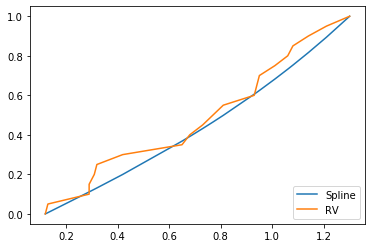

In [12]:
Mstar = np.zeros(len(systems))
detection_methods = []
for i, s in enumerate(systems):
    Mstar[i] = s.Mstar
    detection_methods.append(s.detection_method)
detection_methods = np.array(detection_methods)

train_x = np.sort(np.squeeze(Mstar[detection_methods == 'Radial Velocity']))
train_y = np.linspace(0, 1, len(train_x))
valid_x = np.sort(np.squeeze(Mstar[detection_methods == 'Transit']))
valid_y = np.linspace(0, 1, len(valid_x))
epsilon = sys.float_info.epsilon

for i in range(1, len(train_x)):                                 #ensure that adjacent RV stars do not have the same mass
    if train_x[i] == train_x[i-1]:                               #epsilon is the smallest difference so that 2 floating
        train_x[i] = train_x[i] + epsilon                        #point numbers can be distinguished
            
train_x = np.sort(np.squeeze(train_x))                           #make sure the new RV distribution is sorted
train_y = np.linspace(0, 1, len(train_x))

transit_systems = []
for i, s in enumerate(systems):
    if s.detection_method == 'Transit':
        transit_systems.append(s)
        
for i in range(len(transit_systems)):                                     #bubble sort transit systems based on Mstar
    for j in range(len(transit_systems)-1):
        if transit_systems[j].Mstar > transit_systems[j+1].Mstar:
            transit_systems[j], transit_systems[j+1] = transit_systems[j+1], transit_systems[j]

p = scipy.interpolate.UnivariateSpline(train_x, train_y)(train_x)
p = (p-min(p))/(max(p)-min(p))                                          #make sure cdf has endpoints between 0 and 1

plt.plot(train_x, p, label='Spline')
plt.plot(train_x, train_y, label='RV')
plt.legend(loc='lower right')
plt.show()

# Bootstrapping

In [13]:
def unfold2darray(arr, detections = detection_methods):
    '''
    This takes a list of lists and outputs 3 lists:
    one for transit, one for RV, and one for mixed
    '''
    arr_transit = []
    arr_rv = []
    arr_mixed = []
    for i in range(len(arr)):
        for j in range(len(arr[i])):
            if detections[i] == 'Transit':
                arr_transit.append(arr[i][j])
            elif detections[i] == 'Radial Velocity':
                arr_rv.append(arr[i][j])
            elif detections[i] == 'Mixed':
                arr_mixed.append(arr[i][j])
    return arr_transit, arr_rv, arr_mixed

def unfold1darray(arr, detections):
    '''
    This takes a list and outputs 3 lists:
    one for transit, one for RV, and one for mixed
    '''
    arr_transit = []
    arr_rv = []
    arr_mixed = []
    for i in range(len(arr)):
        if detections[i] == 'Transit':
            arr_transit.append(arr[i])
        elif detections[i] == 'Radial Velocity':
            arr_rv.append(arr[i])
        elif detections[i] == 'Mixed':
            arr_mixed.append(arr[i])
    return arr_transit, arr_rv, arr_mixed

def pairwise(arr, detections = detection_methods):
    arr_j = []
    arr_j_plus_one = []
    disc_methods = []
    
    for i in range(len(arr)):
        for j in range(len(arr[i])):
            if j+1 < len(arr[i]):
                arr_j.append(arr[i][j])
                arr_j_plus_one.append(arr[i][j+1])
                disc_methods.append(detections[i])
    
    ratio = []
    for i in range(len(arr_j)):
        ratio.append(arr_j_plus_one[i]/arr_j[i])
        
    return np.array(ratio), np.array(disc_methods)

def compute_KS_AD(arr1, arr2):
    arr1 = np.sort(np.squeeze(arr1))
    arr2 = np.sort(np.squeeze(arr2))
    
    KS = np.array(stats.ks_2samp(arr1, arr2))[1]
    AD = stats.anderson_ksamp([arr1, arr2])[2]
    
    return [KS, AD]

KS = {'m': [], 'r': [], 'p': [], 'Q': [], 'M': [], 'S': [], 'C': [], 'pi': [], 'nu': [], 'rho': []}
AD = {'m': [], 'r': [], 'p': [], 'Q': [], 'M': [], 'S': [], 'C': [], 'pi': [], 'nu': [], 'rho': []}

for z in range(NTRIALS):                                             #actual bootstrapping starts here
    bootstrap_systems = []
    indices = []
    for i in range(0, len(valid_x), 1):
        indices.append(i)
    for i in range(NBOOT): 
        r = np.random.uniform()
        j = 0
        while p[j] <= r:
            j = j + 1
        bootstrap_systems.append(transit_systems[j])

    sv_systems = []
    for i, s in enumerate(systems):
        if s.detection_method != 'Transit':
            sv_systems.append(s)
    systems = sv_systems
    for i, s in enumerate(bootstrap_systems):
        systems.append(s)
        
    Nsys = len(systems)
    N  = np.zeros(Nsys)
    mu = np.zeros(Nsys)
    Q  = np.zeros(Nsys)
    M  = np.zeros(Nsys)
    S  = np.zeros(Nsys)
    C  = np.zeros(Nsys)
    Mstar = np.zeros(Nsys)
    Rstar = np.zeros(Nsys)
    logmu_over_N = np.zeros(Nsys)
    detection_methods = ['']*Nsys
    periods = [[0]]*Nsys
    masses = [[0]]*Nsys
    radii = [[0]]*Nsys
    starnames = ['']*Nsys
    for i, s in enumerate(systems):
        N[i]  = s.N
        mu[i] = s.mu
        Q[i]  = s.Q
        M[i]  = s.M
        S[i]  = s.S
        C[i]  = s.C
        Mstar[i] = s.Mstar
        Rstar[i] = s.Rstar
        logmu_over_N[i] = np.log10(s.mu/s.N)
        detection_methods[i] = s.detection_method
        periods[i] = s.periods
        masses[i] = s.masses
        radii[i] = s.radii
        starnames[i] = s.starname
    logmu = np.log10(mu)
    detection_methods = np.array(detection_methods)
    starnames = np.array(starnames)
    
    m_transit, m_rv, m_mixed = unfold2darray(masses)
    KS['m'].append(compute_KS_AD(m_transit, m_rv)[0])
    AD['m'].append(compute_KS_AD(m_transit, m_rv)[1])
    
    r_transit, r_rv, r_mixed = unfold2darray(radii)
    KS['r'].append(compute_KS_AD(r_transit, r_rv)[0])
    AD['r'].append(compute_KS_AD(r_transit, r_rv)[1])
    
    p_transit, p_rv, p_mixed = unfold2darray(periods)
    KS['p'].append(compute_KS_AD(p_transit, p_rv)[0])
    AD['p'].append(compute_KS_AD(p_transit, p_rv)[1])
    
    Q_transit, Q_rv, Q_mixed = unfold1darray(Q, detection_methods)
    KS['Q'].append(compute_KS_AD(Q_transit, Q_rv)[0])
    AD['Q'].append(compute_KS_AD(Q_transit, Q_rv)[1])
    
    M_transit, M_rv, M_mixed = unfold1darray(M, detection_methods) 
    KS['M'].append(compute_KS_AD(M_transit, M_rv)[0])
    AD['M'].append(compute_KS_AD(M_transit, M_rv)[1])
    
    S_transit, S_rv, S_mixed = unfold1darray(S, detection_methods)
    KS['S'].append(compute_KS_AD(S_transit, S_rv)[0])
    AD['S'].append(compute_KS_AD(S_transit, S_rv)[1])
    
    C_transit, C_rv, C_mixed = unfold1darray(C, detection_methods)
    KS['C'].append(compute_KS_AD(C_transit, C_rv)[0])
    AD['C'].append(compute_KS_AD(C_transit, C_rv)[1])
    
    pi, disc_methods = pairwise(periods)
    pi_transit, pi_rv, pi_mixed = unfold1darray(pi, disc_methods) 
    KS['pi'].append(compute_KS_AD(pi_transit, pi_rv)[0])
    AD['pi'].append(compute_KS_AD(pi_transit, pi_rv)[1])
    
    nu, disc_methods = pairwise(masses)
    nu_transit, nu_rv, nu_mixed = unfold1darray(nu, disc_methods)
    KS['nu'].append(compute_KS_AD(nu_transit, nu_rv)[0])
    AD['nu'].append(compute_KS_AD(nu_transit, nu_rv)[1])
    
    rho, disc_methods = pairwise(radii)
    rho_transit, rho_rv, rho_mixed = unfold1darray(rho, disc_methods)
    KS['rho'].append(compute_KS_AD(rho_transit, rho_rv)[0])
    AD['rho'].append(compute_KS_AD(rho_transit, rho_rv)[1])

C:\Users\djhoo\Miniconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: p-value floored: true value smaller than 0.001
C:\Users\djhoo\Miniconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: p-value capped: true value larger than 0.25


In [14]:
print('Number of RV systems: %d' %len(detection_methods[detection_methods == 'Radial Velocity']))
print('Number of Transit systems: %d' %len(detection_methods[detection_methods == 'Transit']))
print('Number of Mixed systems: %d' %len(detection_methods[detection_methods == 'Mixed']))

Number of RV systems: 21
Number of Transit systems: 16
Number of Mixed systems: 18


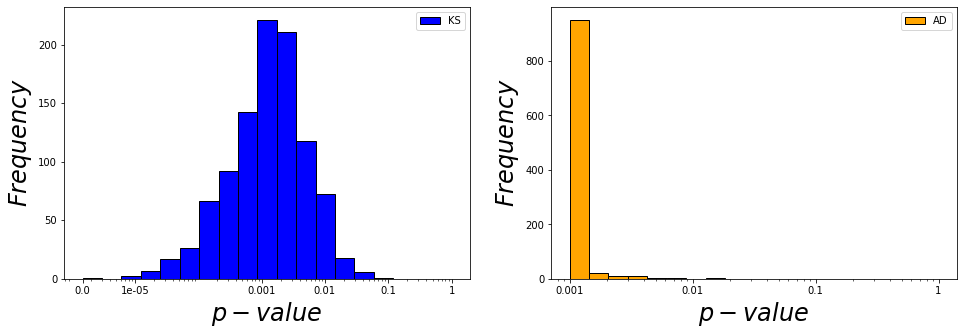

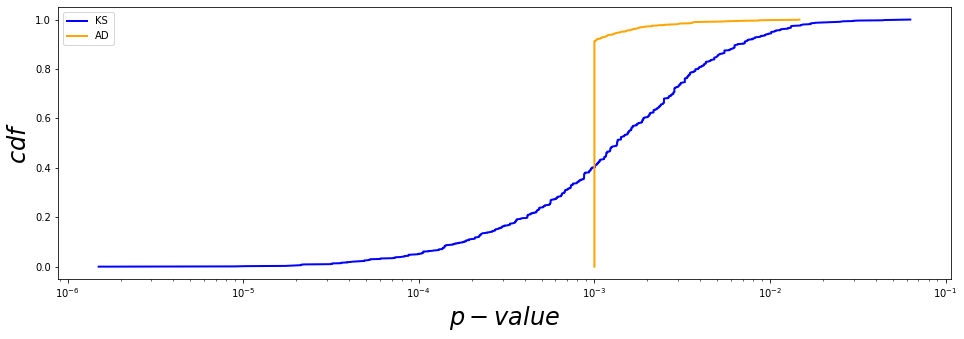

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
ax = axes[0]
ax.set_xscale('log')
ax.hist(KS['m'], bins=np.logspace(np.log10(min(KS['m'])), np.log10(1), 20), edgecolor='k', histtype='bar', label='KS', \
       color = 'blue')
ax.set_xticks([min(KS['m']), 1e-5, 0.001, 0.01, 0.1, 1])
ax.set_xticklabels([min(KS['m']).round(1), 1e-5, 0.001, 0.01, 0.1, 1])
ax.set_xlabel(r'$p-value$', fontsize=24)
ax.set_ylabel(r'$Frequency$', fontsize=24)
ax.legend(loc='upper right')

ax = axes[1]
ax.set_xscale('log')
ax.hist(AD['m'], bins=np.logspace(np.log10(min(AD['m'])), np.log10(1), 20), edgecolor='k', histtype='bar', label='AD', \
       color = 'orange')
ax.set_xticks([0.001, 0.01, 0.1, 1])
ax.set_xticklabels([0.001, 0.01, 0.1, 1])
ax.set_xlabel(r'$p-value$', fontsize=24)
ax.set_ylabel(r'$Frequency$', fontsize=24)
ax.legend(loc='upper right')

plt.figure(figsize=(16,5))
KS['m'] = np.sort(np.squeeze(KS['m']))
AD['m'] = np.sort(np.squeeze(AD['m']))
plt.xscale('log')
plt.plot(KS['m'], np.linspace(0, 1, len(KS['m'])), lw=2, color = 'blue', label = 'KS')
plt.plot(AD['m'], np.linspace(0, 1, len(AD['m'])), lw=2, color = 'orange', label = 'AD')
plt.xlabel(r'$p-value$', fontsize=24)
plt.ylabel(r'$cdf$', fontsize=24)
plt.legend(loc='upper left')

plt.show()

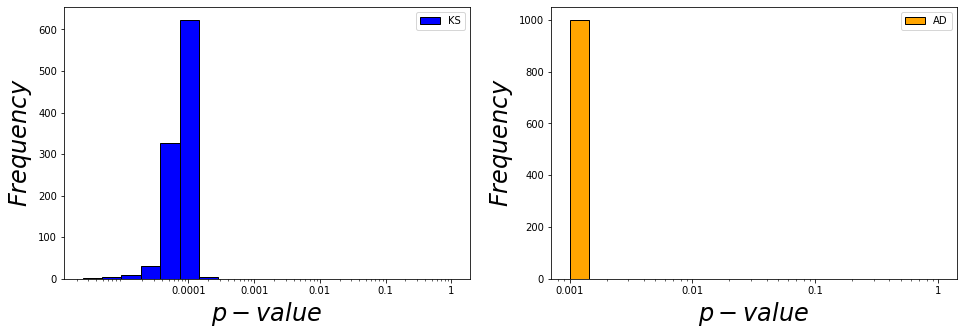

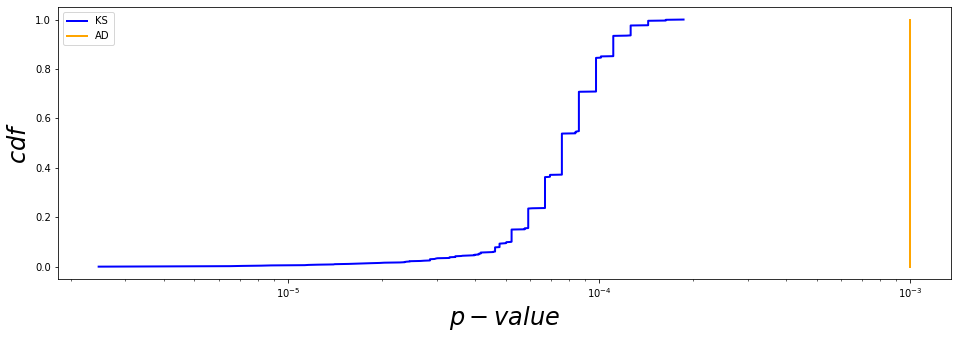

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
ax = axes[0]
ax.set_xscale('log')
ax.hist(KS['r'], bins=np.logspace(np.log10(min(KS['r'])), np.log10(1), 20), edgecolor='k', histtype='bar', label='KS', \
       color = 'blue')
ax.set_xticks([0.0001, 0.001, 0.01, 0.1, 1])
ax.set_xticklabels([0.0001, 0.001, 0.01, 0.1, 1])
ax.set_xlabel(r'$p-value$', fontsize=24)
ax.set_ylabel(r'$Frequency$', fontsize=24)
ax.legend(loc='upper right')

ax = axes[1]
ax.set_xscale('log')
ax.hist(AD['r'], bins=np.logspace(np.log10(min(AD['r'])), np.log10(1), 20), edgecolor='k', histtype='bar', label='AD', \
       color = 'orange')
ax.set_xticks([0.001, 0.01, 0.1, 1])
ax.set_xticklabels([0.001, 0.01, 0.1, 1])
ax.set_xlabel(r'$p-value$', fontsize=24)
ax.set_ylabel(r'$Frequency$', fontsize=24)
ax.legend(loc='upper right')

plt.figure(figsize=(16,5))
KS['r'] = np.sort(np.squeeze(KS['r']))
AD['r'] = np.sort(np.squeeze(AD['r']))
plt.xscale('log')
plt.plot(KS['r'], np.linspace(0, 1, len(KS['r'])), lw=2, color = 'blue', label = 'KS')
plt.plot(AD['r'], np.linspace(0, 1, len(AD['r'])), lw=2, color = 'orange', label = 'AD')
plt.xlabel(r'$p-value$', fontsize=24)
plt.ylabel(r'$cdf$', fontsize=24)
plt.legend(loc='upper left')

plt.show()

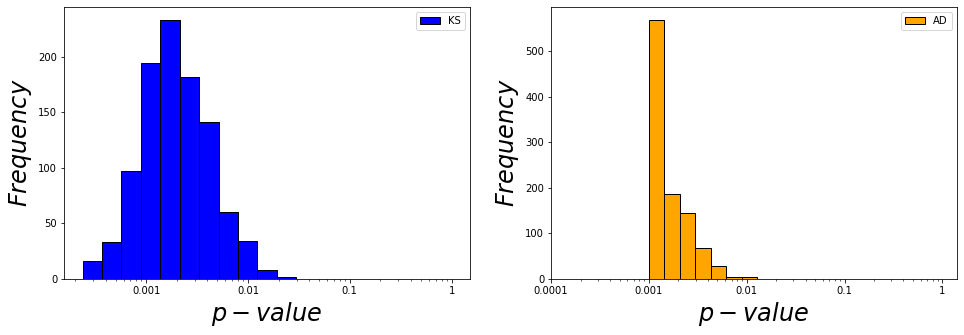

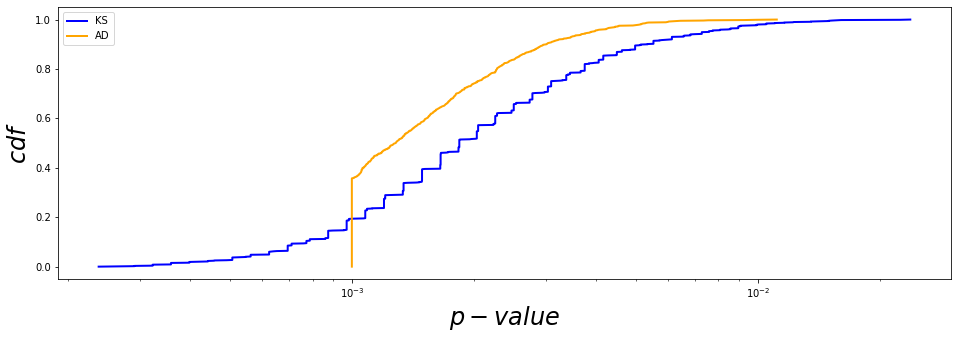

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
ax = axes[0]
ax.set_xscale('log')
ax.hist(KS['p'], bins=np.logspace(np.log10(min(KS['p'])), np.log10(1), 20), edgecolor='k', histtype='bar', label='KS', \
       color = 'blue')
ax.set_xticks([0.001, 0.01, 0.1, 1])
ax.set_xticklabels([0.001, 0.01, 0.1, 1])
ax.set_xlabel(r'$p-value$', fontsize=24)
ax.set_ylabel(r'$Frequency$', fontsize=24)
ax.legend(loc='upper right')

ax = axes[1]
ax.set_xscale('log')
ax.hist(AD['p'], bins=np.logspace(np.log10(min(AD['p'])), np.log10(1), 20), edgecolor='k', histtype='bar', label='AD', \
       color = 'orange')
ax.set_xticks([0.0001, 0.001, 0.01, 0.1, 1])
ax.set_xticklabels([0.0001, 0.001, 0.01, 0.1, 1])
ax.set_xlabel(r'$p-value$', fontsize=24)
ax.set_ylabel(r'$Frequency$', fontsize=24)
ax.legend(loc='upper right')

plt.figure(figsize=(16,5))
KS['p'] = np.sort(np.squeeze(KS['p']))
AD['p'] = np.sort(np.squeeze(AD['p']))
plt.xscale('log')
plt.plot(KS['p'], np.linspace(0, 1, len(KS['p'])), lw=2, color = 'blue', label = 'KS')
plt.plot(AD['p'], np.linspace(0, 1, len(AD['p'])), lw=2, color = 'orange', label = 'AD')
plt.xlabel(r'$p-value$', fontsize=24)
plt.ylabel(r'$cdf$', fontsize=24)
plt.legend(loc='upper left')

plt.show()

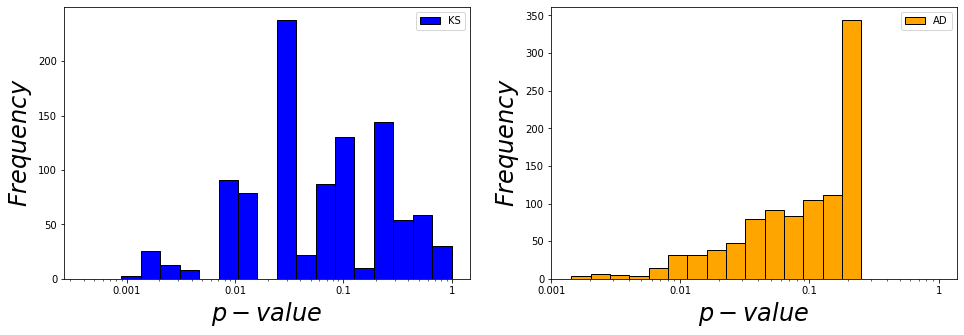

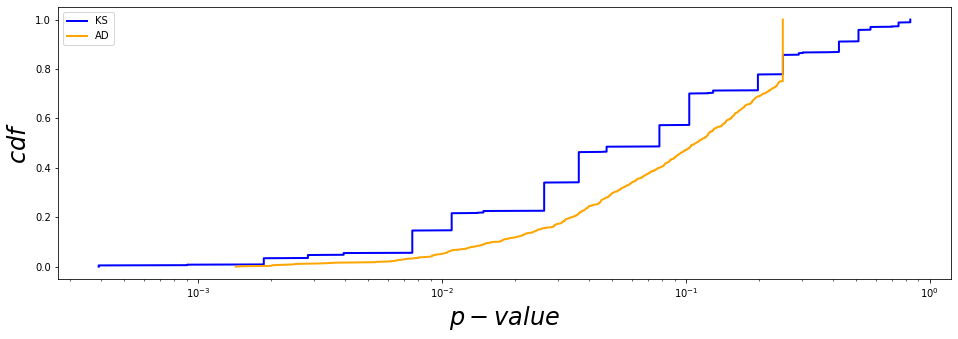

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
ax = axes[0]
ax.set_xscale('log')
ax.hist(KS['Q'], bins=np.logspace(np.log10(min(KS['Q'])), np.log10(1), 20), edgecolor='k', histtype='bar', label='KS', \
       color = 'blue')
ax.set_xticks([0.001, 0.01, 0.1, 1])
ax.set_xticklabels([0.001, 0.01, 0.1, 1])
ax.set_xlabel(r'$p-value$', fontsize=24)
ax.set_ylabel(r'$Frequency$', fontsize=24)
ax.legend(loc='upper right')

ax = axes[1]
ax.set_xscale('log')
ax.hist(AD['Q'], bins=np.logspace(np.log10(min(AD['Q'])), np.log10(1), 20), edgecolor='k', histtype='bar', label='AD', \
       color = 'orange')
ax.set_xticks([0.001, 0.01, 0.1, 1])
ax.set_xticklabels([0.001, 0.01, 0.1, 1])
ax.set_xlabel(r'$p-value$', fontsize=24)
ax.set_ylabel(r'$Frequency$', fontsize=24)
ax.legend(loc='upper right')

plt.figure(figsize=(16,5))
KS['Q'] = np.sort(np.squeeze(KS['Q']))
AD['Q'] = np.sort(np.squeeze(AD['Q']))
plt.xscale('log')
plt.plot(KS['Q'], np.linspace(0, 1, len(KS['Q'])), lw=2, color = 'blue', label = 'KS')
plt.plot(AD['Q'], np.linspace(0, 1, len(AD['Q'])), lw=2, color = 'orange', label = 'AD')
plt.xlabel(r'$p-value$', fontsize=24)
plt.ylabel(r'$cdf$', fontsize=24)
plt.legend(loc='upper left')

plt.show()

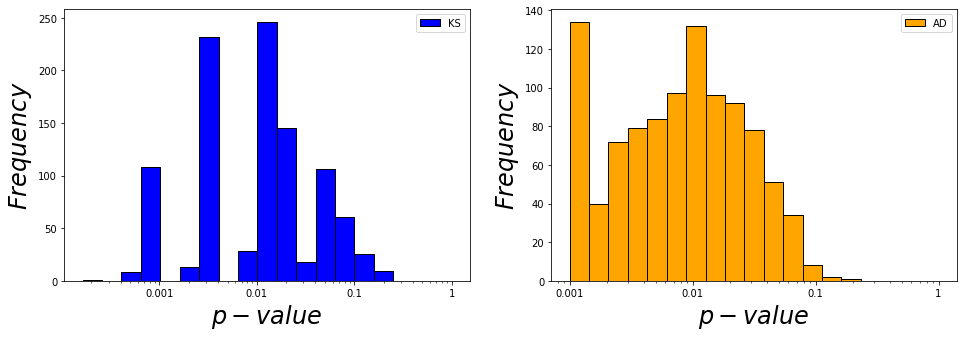

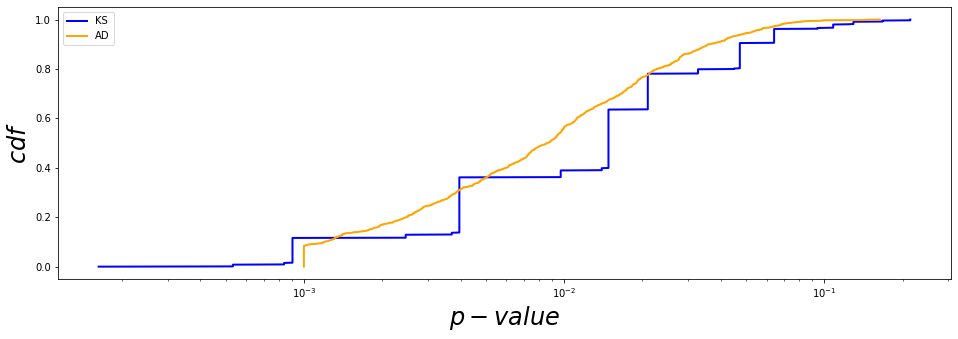

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
ax = axes[0]
ax.set_xscale('log')
ax.hist(KS['M'], bins=np.logspace(np.log10(min(KS['M'])), np.log10(1), 20), edgecolor='k', histtype='bar', label='KS', \
       color = 'blue')
ax.set_xticks([0.001, 0.01, 0.1, 1])
ax.set_xticklabels([0.001, 0.01, 0.1, 1])
ax.set_xlabel(r'$p-value$', fontsize=24)
ax.set_ylabel(r'$Frequency$', fontsize=24)
ax.legend(loc='upper right')

ax = axes[1]
ax.set_xscale('log')
ax.hist(AD['M'], bins=np.logspace(np.log10(min(AD['M'])), np.log10(1), 20), edgecolor='k', histtype='bar', label='AD', \
       color = 'orange')
ax.set_xticks([0.001, 0.01, 0.1, 1])
ax.set_xticklabels([0.001, 0.01, 0.1, 1])
ax.set_xlabel(r'$p-value$', fontsize=24)
ax.set_ylabel(r'$Frequency$', fontsize=24)
ax.legend(loc='upper right')

plt.figure(figsize=(16,5))
KS['M'] = np.sort(np.squeeze(KS['M']))
AD['M'] = np.sort(np.squeeze(AD['M']))
plt.xscale('log')
plt.plot(KS['M'], np.linspace(0, 1, len(KS['M'])), lw=2, color = 'blue', label = 'KS')
plt.plot(AD['M'], np.linspace(0, 1, len(AD['M'])), lw=2, color = 'orange', label = 'AD')
plt.xlabel(r'$p-value$', fontsize=24)
plt.ylabel(r'$cdf$', fontsize=24)
plt.legend(loc='upper left')

plt.show()

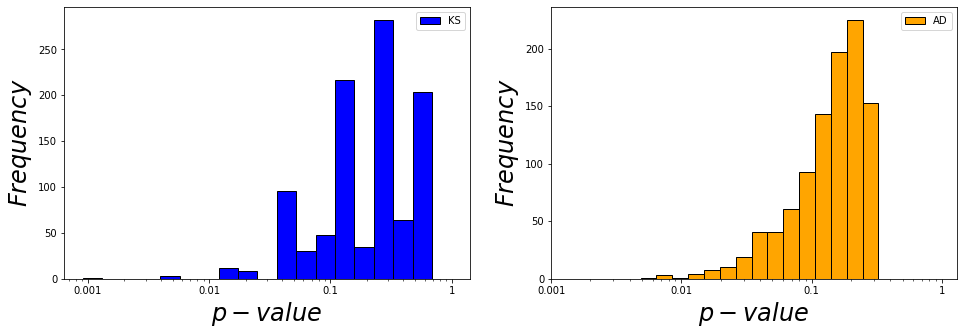

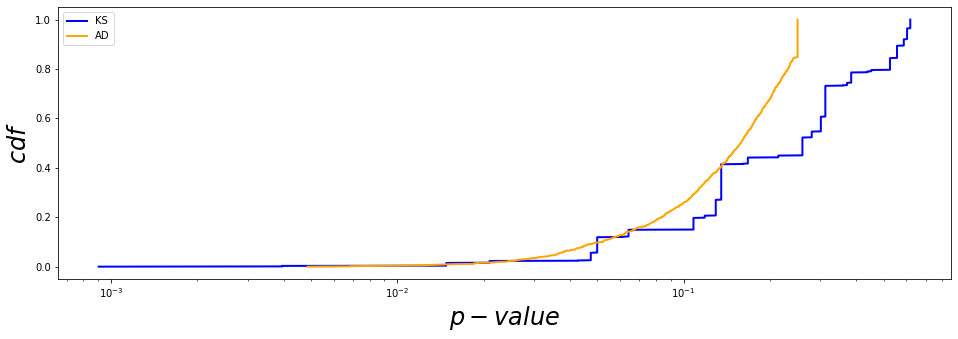

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
ax = axes[0]
ax.set_xscale('log')
ax.hist(KS['S'], bins=np.logspace(np.log10(min(KS['S'])), np.log10(1), 20), edgecolor='k', histtype='bar', label='KS', \
       color = 'blue')
ax.set_xticks([0.001, 0.01, 0.1, 1])
ax.set_xticklabels([0.001, 0.01, 0.1, 1])
ax.set_xlabel(r'$p-value$', fontsize=24)
ax.set_ylabel(r'$Frequency$', fontsize=24)
ax.legend(loc='upper right')

ax = axes[1]
ax.set_xscale('log')
ax.hist(AD['S'], bins=np.logspace(np.log10(min(AD['S'])), np.log10(1), 20), edgecolor='k', histtype='bar', label='AD', \
       color = 'orange')
ax.set_xticks([0.001, 0.01, 0.1, 1])
ax.set_xticklabels([0.001, 0.01, 0.1, 1])
ax.set_xlabel(r'$p-value$', fontsize=24)
ax.set_ylabel(r'$Frequency$', fontsize=24)
ax.legend(loc='upper right')

plt.figure(figsize=(16,5))
KS['S'] = np.sort(np.squeeze(KS['S']))
AD['S'] = np.sort(np.squeeze(AD['S']))
plt.xscale('log')
plt.plot(KS['S'], np.linspace(0, 1, len(KS['S'])), lw=2, color = 'blue', label = 'KS')
plt.plot(AD['S'], np.linspace(0, 1, len(AD['S'])), lw=2, color = 'orange', label = 'AD')
plt.xlabel(r'$p-value$', fontsize=24)
plt.ylabel(r'$cdf$', fontsize=24)
plt.legend(loc='upper left')

plt.show()

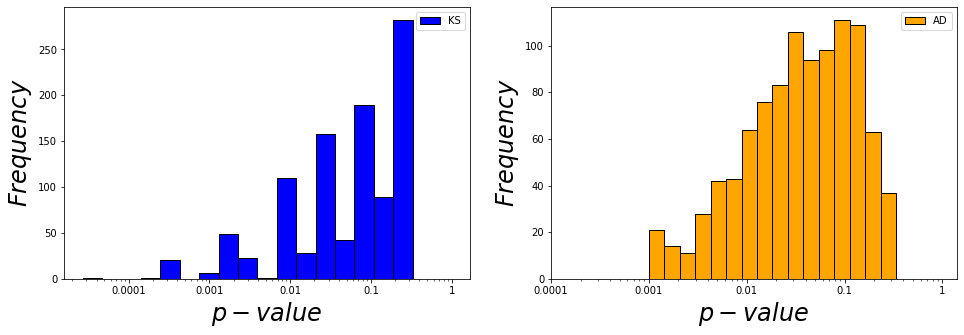

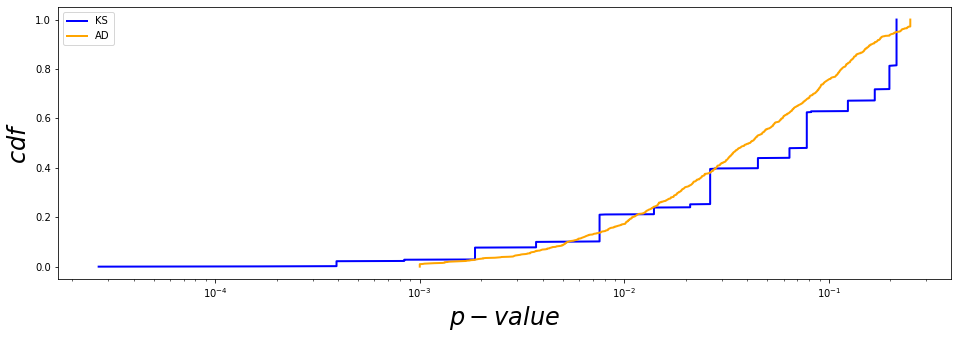

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
ax = axes[0]
ax.set_xscale('log')
ax.hist(KS['C'], bins=np.logspace(np.log10(min(KS['C'])), np.log10(1), 20), edgecolor='k', histtype='bar', label='KS', \
       color = 'blue')
ax.set_xticks([0.0001, 0.001, 0.01, 0.1, 1])
ax.set_xticklabels([0.0001, 0.001, 0.01, 0.1, 1])
ax.set_xlabel(r'$p-value$', fontsize=24)
ax.set_ylabel(r'$Frequency$', fontsize=24)
ax.legend(loc='upper right')

ax = axes[1]
ax.set_xscale('log')
ax.hist(AD['C'], bins=np.logspace(np.log10(min(AD['C'])), np.log10(1), 20), edgecolor='k', histtype='bar', label='AD', \
       color = 'orange')
ax.set_xticks([0.0001, 0.001, 0.01, 0.1, 1])
ax.set_xticklabels([0.0001, 0.001, 0.01, 0.1, 1])
ax.set_xlabel(r'$p-value$', fontsize=24)
ax.set_ylabel(r'$Frequency$', fontsize=24)
ax.legend(loc='upper right')

plt.figure(figsize=(16,5))
KS['C'] = np.sort(np.squeeze(KS['C']))
AD['C'] = np.sort(np.squeeze(AD['C']))
plt.xscale('log')
plt.plot(KS['C'], np.linspace(0, 1, len(KS['C'])), lw=2, color = 'blue', label = 'KS')
plt.plot(AD['C'], np.linspace(0, 1, len(AD['C'])), lw=2, color = 'orange', label = 'AD')
plt.xlabel(r'$p-value$', fontsize=24)
plt.ylabel(r'$cdf$', fontsize=24)
plt.legend(loc='upper left')

plt.show()

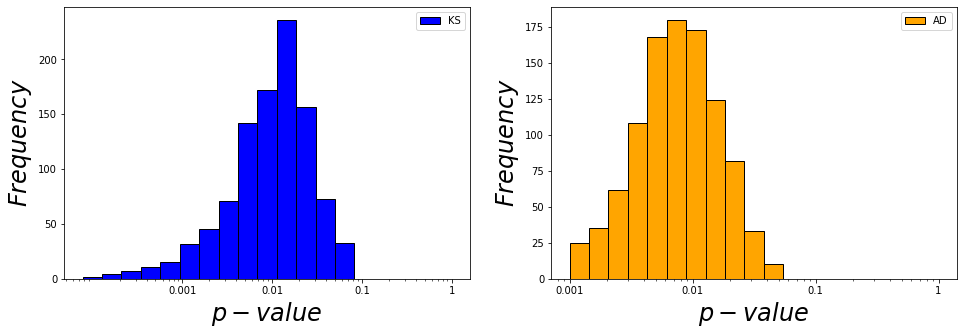

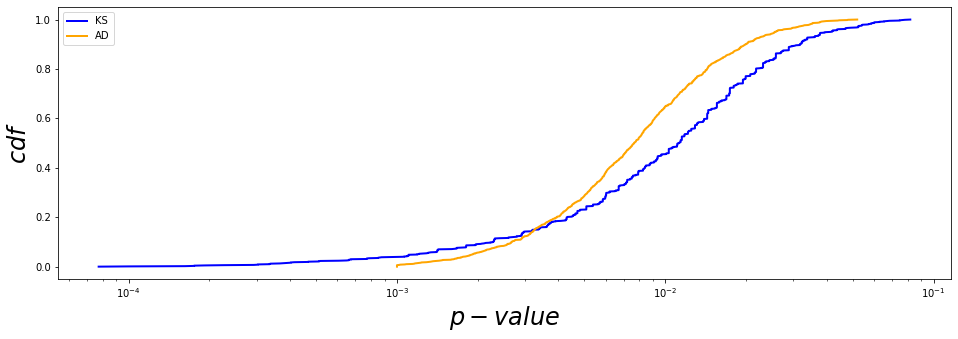

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
ax = axes[0]
ax.set_xscale('log')
ax.hist(KS['pi'], bins=np.logspace(np.log10(min(KS['pi'])), np.log10(1), 20), edgecolor='k', histtype='bar', label='KS', \
       color = 'blue')
ax.set_xticks([0.001, 0.01, 0.1, 1])
ax.set_xticklabels([0.001, 0.01, 0.1, 1])
ax.set_xlabel(r'$p-value$', fontsize=24)
ax.set_ylabel(r'$Frequency$', fontsize=24)
ax.legend(loc='upper right')

ax = axes[1]
ax.set_xscale('log')
ax.hist(AD['pi'], bins=np.logspace(np.log10(min(AD['pi'])), np.log10(1), 20), edgecolor='k', histtype='bar', label='AD', \
       color = 'orange')
ax.set_xticks([0.001, 0.01, 0.1, 1])
ax.set_xticklabels([0.001, 0.01, 0.1, 1])
ax.set_xlabel(r'$p-value$', fontsize=24)
ax.set_ylabel(r'$Frequency$', fontsize=24)
ax.legend(loc='upper right')

plt.figure(figsize=(16,5))
KS['pi'] = np.sort(np.squeeze(KS['pi']))
AD['pi'] = np.sort(np.squeeze(AD['pi']))
plt.xscale('log')
plt.plot(KS['pi'], np.linspace(0, 1, len(KS['pi'])), lw=2, color = 'blue', label = 'KS')
plt.plot(AD['pi'], np.linspace(0, 1, len(AD['pi'])), lw=2, color = 'orange', label = 'AD')
plt.xlabel(r'$p-value$', fontsize=24)
plt.ylabel(r'$cdf$', fontsize=24)
plt.legend(loc='upper left')

plt.show()

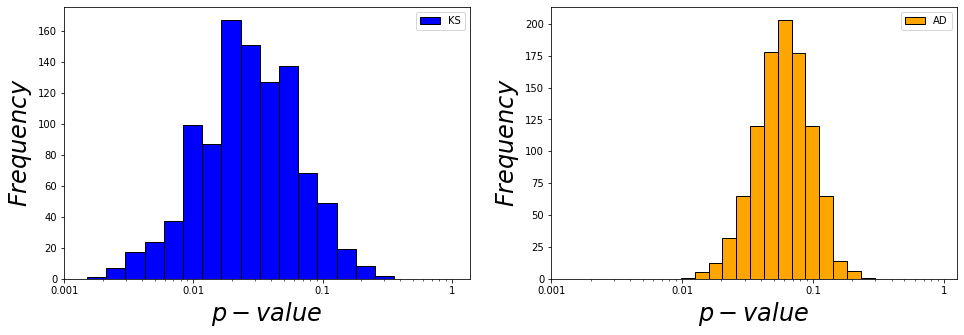

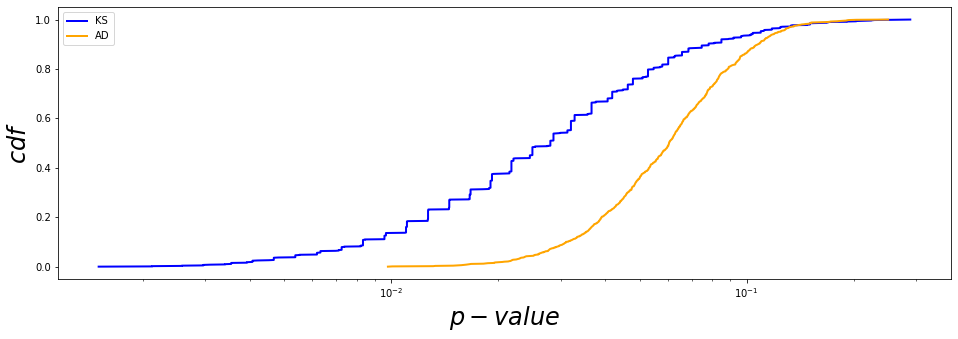

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
ax = axes[0]
ax.set_xscale('log')
ax.hist(KS['nu'], bins=np.logspace(np.log10(min(KS['nu'])), np.log10(1), 20), edgecolor='k', histtype='bar', label='KS', \
       color = 'blue')
ax.set_xticks([0.001, 0.01, 0.1, 1])
ax.set_xticklabels([0.001, 0.01, 0.1, 1])
ax.set_xlabel(r'$p-value$', fontsize=24)
ax.set_ylabel(r'$Frequency$', fontsize=24)
ax.legend(loc='upper right')

ax = axes[1]
ax.set_xscale('log')
ax.hist(AD['nu'], bins=np.logspace(np.log10(min(AD['nu'])), np.log10(1), 20), edgecolor='k', histtype='bar', label='AD', \
       color = 'orange')
ax.set_xticks([0.001, 0.01, 0.1, 1])
ax.set_xticklabels([0.001, 0.01, 0.1, 1])
ax.set_xlabel(r'$p-value$', fontsize=24)
ax.set_ylabel(r'$Frequency$', fontsize=24)
ax.legend(loc='upper right')

plt.figure(figsize=(16,5))
KS['nu'] = np.sort(np.squeeze(KS['nu']))
AD['nu'] = np.sort(np.squeeze(AD['nu']))
plt.xscale('log')
plt.plot(KS['nu'], np.linspace(0, 1, len(KS['nu'])), lw=2, color = 'blue', label = 'KS')
plt.plot(AD['nu'], np.linspace(0, 1, len(AD['nu'])), lw=2, color = 'orange', label = 'AD')
plt.xlabel(r'$p-value$', fontsize=24)
plt.ylabel(r'$cdf$', fontsize=24)
plt.legend(loc='upper left')

plt.show()

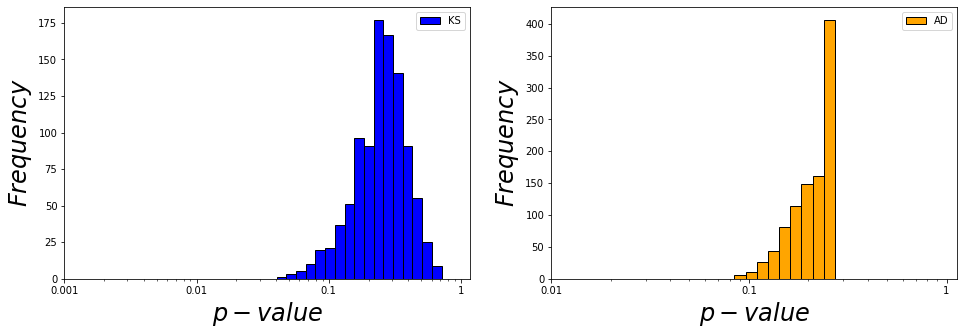

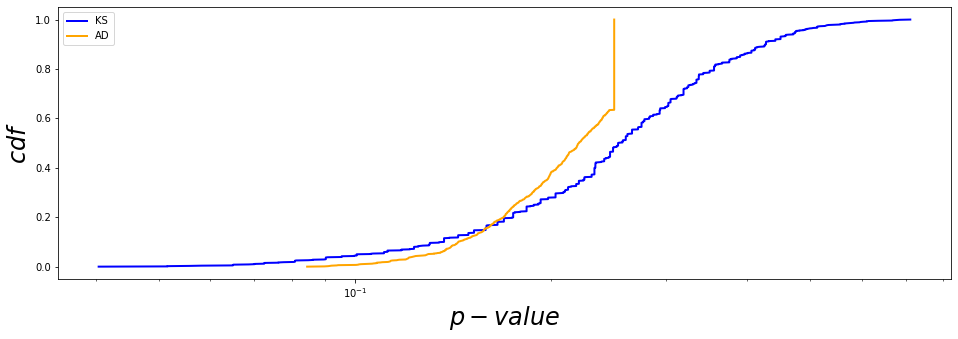

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
ax = axes[0]
ax.set_xscale('log')
ax.hist(KS['rho'], bins=np.logspace(np.log10(min(KS['rho'])), np.log10(1), 20), edgecolor='k', histtype='bar', label='KS', \
       color = 'blue')
ax.set_xticks([0.001, 0.01, 0.1, 1])
ax.set_xticklabels([0.001, 0.01, 0.1, 1])
ax.set_xlabel(r'$p-value$', fontsize=24)
ax.set_ylabel(r'$Frequency$', fontsize=24)
ax.legend(loc='upper right')

ax = axes[1]
ax.set_xscale('log')
ax.hist(AD['rho'], bins=np.logspace(np.log10(min(AD['rho'])), np.log10(1), 20), edgecolor='k', histtype='bar', label='AD', \
       color = 'orange')
ax.set_xticks([0.01, 0.1, 1])
ax.set_xticklabels([0.01, 0.1, 1])
ax.set_xlabel(r'$p-value$', fontsize=24)
ax.set_ylabel(r'$Frequency$', fontsize=24)
ax.legend(loc='upper right')

plt.figure(figsize=(16,5))
KS['rho'] = np.sort(np.squeeze(KS['rho']))
AD['rho'] = np.sort(np.squeeze(AD['rho']))
plt.xscale('log')
plt.plot(KS['rho'], np.linspace(0, 1, len(KS['rho'])), lw=2, color = 'blue', label = 'KS')
plt.plot(AD['rho'], np.linspace(0, 1, len(AD['rho'])), lw=2, color = 'orange', label = 'AD')
plt.xlabel(r'$p-value$', fontsize=24)
plt.ylabel(r'$cdf$', fontsize=24)
plt.legend(loc='upper left')

plt.show()